Copyright 2018 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Datathon Tutorial

The aim of this tutorial is to get you familiarized with BigQuery to query/filter/aggregate/export data with Python.

## Prerequisites

You should already have had a valid Gmail account registered with the datathon organizers.
  * If you do not have a Gmail account, you can create one at http://www.gmail.com. You need to notify datathon organizers to register your new account for data access.
  * If you have not yet signed the data use agreement (DUA) sent by the organizers, please do so immediately to get access to the MIMIC-III dataset.

## Setup

To be able to run the queries in this tutorial, you need to create a copy of this Colab notebook by clicking "File" > "Save a copy in Drive..." menu.
You can share your copy with your teammates by clicking on the "SHARE" button on the top-right corner of your Colab notebook copy. Everyone with "Edit" permission is able to modify the notebook at the same time, so it is a great way for team collaboration. Before running any cell in this colab, please make sure there is a green check mark before "CONNECTED" on top right corner, if not, please click "CONNECTED" button to connect to a random backend.

Now that you have done the initial setup, let us start playing with the data. First, you need to run some initialization code. You can run the following cell by clicking on the triangle button when you hover over the [ ] space on the top-left corner of the code cell below.

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

Before running any queries using BigQuery, you need to first authenticate yourself by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Gmail account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter.

In [0]:
auth.authenticate_user() 

The data-hosting project `amsterdamumcdb-data.amsterdamumcdb_v_1_0_1` has read-only access, as a result, you need to set a default project that you have BigQuery access to. A shared project should be created by the event organizers, and we will be using it throughout this tutorial.

Note that during the datathon, all participants will be divided into teams and a Google Cloud project will be created for each team specifically. That project would be the preferred project to use. For now we'll stick with the shared project for the purpose of the tutorial.

After datathon is finished, the shared project may either lock down access or be deleted, it's still possible to run queries from a project you own personally as long as you have access to the dataset hosting project.

Change the variable project_id below to list the project you are using.

In [0]:
project_id='milandaticu2020'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

Let's define a few methods to wrap BigQuery operations, so that we don't have to write the configurations again and again.

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

OK, that's it for setup, now let's get our hands on the AmsterdamUMC database data!

## Analysis

Let's start with a simple analysis regarding the admission time of ICU patients to the AmsterdamUMC database


In [0]:
df = run_query('''
SELECT  AD.patientID, 
        AD.admissionID,
        AD.admittedat
FROM `amsterdamumcdb-data.amsterdamumcdb_v_1_0_1.admissions` as AD 
ORDER BY AD.admissionid ASC
LIMIT 10
''')

df.head()

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


,patientID,admissionID,admittedat
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,0


Real Admission Time
Patients were often admitted to the ICU from the moment admission was 'expected'. That is, therefore, often earlier then actual admission time. Therefore, as a convention, the real admission time to the AmsterdamUMC db is set at the first measured heart frequency.

The query below shows how to derive the real admission time (relative to the registered  admission time in the database.

***PLEASE NOTE: measuredat columns are 'miliseconds' since admissiontime***


In [0]:
df = run_query('''
SELECT  NU.admissionid,
        MIN (NU.measuredat) /1000 /3600 AS AdmissionTime_inHours 
        -- /1000 to turn from miliseconds to second and /3600 to transform from seconds to hours
FROM `amsterdamumcdb-data.amsterdamumcdb_v_1_0_1.numericitems` as NU 
WHERE NU.itemid = 6640
GROUP BY NU.admissionid
ORDER BY NU.admissionid ASC

''')
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


,admissionid,AdmissionTime_inHours
0,0,5.700000
1,1,0.833333
2,2,0.200000
3,3,1.900000
4,4,1.450000


SAME AS ABOVE INCLUDING A JOIN WITH THE ADMISSION TABLE

In [0]:
df = run_query('''
SELECT   AD.PatientID
		    ,NU.admissionid
        ,MIN (NU.measuredat) /1000 /3600 AS AdmissionTime_inHours 
FROM `amsterdamumcdb-data.amsterdamumcdb_v_1_0_1.numericitems` as NU 
LEFT JOIN `amsterdamumcdb-data.amsterdamumcdb_v_1_0_1.admissions` as AD
ON NU.admissionid = AD.admissionid
WHERE NU.itemid = 6640 
GROUP BY AD.patientid, NU.admissionid
ORDER BY AD.patientid, NU.admissionid ASC
''')
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


,PatientID,admissionid,AdmissionTime_inHours
0,0,0,5.700000
1,1,1,0.833333
2,2,2,0.200000
3,3,3,1.900000
4,4,4,1.450000


In [0]:
df = run_query('''
SELECT itemid, item, count(itemid) as count
    FROM `amsterdamumcdb-data.amsterdamumcdb_v_1_0_1.numericitems`
    as unique_items_table
    WHERE islabresult = 1
    group by itemid, item
    order by count(itemid) DESC
    limit 100
''')
df.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


,itemid,item,count
0,9947,Glucose (bloed),825213
1,9990,pCO2 (bloed),663145
2,12310,pH (bloed),663115
3,9992,Act.HCO3 (bloed),660773
4,9994,B.E. (bloed),657978


## Begin MIMIC-III queries
### Map through `LEVEL1' variables of the *MIMIC-III Benchmark* paper

In [0]:
itemid_to_variable = pd.read_csv('https://raw.githubusercontent.com/YerevaNN/mimic3-benchmarks/master/mimic3benchmark/resources/itemid_to_variable_map.csv')
itemid_to_variable = itemid_to_variable.loc[itemid_to_variable['LEVEL2'].notnull()]
def get_ids_string(itemid_to_variable, table):
    ids = list(itemid_to_variable.loc[itemid_to_variable['LINKSTO'] == table, 'ITEMID'].values)
    ids = [str(i) for i in ids]
    ids_string = '(' + ', '.join(ids)[:-1] + ')'
    return ids_string
lab_ids = get_ids_string(itemid_to_variable, 'labevents')
chartevents_ids = get_ids_string(itemid_to_variable, 'chartevents')

In [0]:
# takes a long time if the limit is too large
limit = '50000'
labevents_mimic = run_query("select subject_id, hadm_id, itemid, charttime, value, valuenum, valueuom from `physionet-data.mimiciii_clinical.labevents` where itemid in {} limit {};".format(lab_ids, limit))
# chartevents_mimic = run_query("select subject_id, hadm_id, itemid, icustay_id, charttime, value, valuenum, valueuom from `physionet-data.mimiciii_clinical.chartevents` where itemid in {} limit {};".format(chartevents_ids, limit))
labevents_mimic.head()

/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom
0,871,141369.0,51127,2125-05-07 14:42:00,1750,1750.0,#/CU MM
1,897,NaN,51094,2200-11-19 16:28:00,6,6.0,None
2,2280,146949.0,50835,2133-12-20 17:23:00,1.4,1.4,g/dL
3,2614,142942.0,51355,2154-05-02 12:43:00,8,8.0,%
4,3113,115820.0,51355,2148-04-21 02:30:00,41,41.0,%


In [0]:
itemid_to_level1_map = itemid_to_variable.set_index('ITEMID')['LEVEL1'].to_dict()
labevents_mimic['clean_label'] = labevents_mimic['itemid'].map(itemid_to_level1_map)
# chartevents_mimic['clean_label'] = chartevents_mimic['itemid'].map(itemid_to_level1_map)

## AmsterdamUCB queries

In [0]:
df1 = pd.read_csv('https://raw.githubusercontent.com/Luca05/ICUnity/master/ICV_itemid_to_variable_map.csv',
  sep=';')
df1.head()
ids = list(df1.parameterid)
ids = [str(i) for i in ids]
ids_string = '(' + ', '.join(ids)[:-1] + ')'
print(ids_string)
dutch_labels = df1['LEVEL1'].unique()
query = 'SELECT itemid, item, value, islabresult FROM `amsterdamumcdb-data.amsterdamumcdb_v_1_0_1.numericitems` as NU WHERE itemid in {} and islabresult = 1 limit {}'.format(ids_string, 50000)
df = run_query(query)
df.shape
df.head(5)
labevents_icv = df1.merge(df, left_on='parameterid', right_on='itemid')

(11893, 11894, 11944, 11978, 11986, 11990, 11998, 12071, 12266, 12279, 12310, 12311, 12442, 13058, 13059, 13060, 13061, 13062, 13063, 13952, 16110, 17982, 6640, 6641, 6642, 6643, 6678, 6679, 6699, 6709, 6789, 6801, 6807, 6810, 6817, 6819, 6850, 8621, 8658, 8659, 8662, 8842, 8843, 8873, 8915, 9558, 9559, 9560, 9561, 9653, 9924, 9927, 9930, 9933, 9935, 9941, 9943, 9945, 9947, 9952, 9960, 9964, 9965, 9975, 9990, 9992, 9993, 9994, 9995, 9996, 10053, 10079, 10267, 10286, 11425, 1154)


/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


GenericGBQException: ignored

## Begin comparison

In [0]:
!pip install googletrans
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from googletrans import Translator
from scipy.stats import ttest_ind
import regex as re

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=9c65c1ffcf50d43c18e01e1bfc45c293f2860a5fe00e4ae9701c3b6dfa1bbae2
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [0]:
english_labels = labevents_mimic['clean_label'].unique()
print(english_labels)
labevents_icv['item'].unique()

['Red blood cell count (ascites)' 'pH' 'Albumin (ascites)' 'Monocytes'
 'Lymphocytes (atypical)' 'Lymphocytes (absolute)' 'Albumin (pleural)'
 'Albumin (urine)' 'Lymphocytes (percent)' 'Lymphocytes'
 'Lactate dehydrogenase' 'Chloride (pleural)'
 'Red blood cell count (other fluid)' 'White blood cell count'
 'Bicarbonate (whole blood)' 'Red blood cell count (CSF)'
 'Red blood cell count (pleural)' 'Bilirubin (total, pleural)'
 'Creatinine' 'Cholesterol (LDL)' 'Bicarbonate (urine)'
 'Cholesterol (pleural)' 'Creatinine (pleural)' 'Calcium (urine)'
 'Creatinine (body fluid)' 'Creatinine (ascites)' 'Creatinine (serum)'
 'Bilirubin (blody fluid)' 'Chloride (body fluid)'
 'Bilirubin (total, ascites)' 'Eosinophils'
 'Red blood cell count (joint fluid)' 'Creatinine (urine)'
 'Albumin (body fluid)' 'Hemoglobin' 'Calcium (body fluid)'
 'Creatinine clearance' 'Chloride (ascites)' 'Calcium' 'Chloride (stool)'
 'Bilirubin (CSF)' 'Glucose' 'Red blood cell count' 'Troponin-I'
 'Troponin-T' 'Chloride (

NameError: ignored

In [0]:
translator = Translator()


def clean(str):
    return re.sub(r"[(),.;@#?!&$]+\ *", " ", str)


def str_similarity(str1, str2):
    if str1 == str2:
        return 1
    else:
        return 0


def str_similarity2(str1, str2):
    return fuzz.token_sort_ratio(str1, str2)


def dist_similarity(dist1, dist2):
    return ttest_ind(dist1.values, dist2.values, equal_var=False)


def deg_overlap(x1, x2, y1, y2):
    # gives an indication of overlap normalised by the largest range
    # can be negative - indicates how far away from overlap we have
    return max((min(x2,y2) - max(x1,y1))/max(x2 - x1, y2 - y1), -1)


def dist_similarity2(dist1, dist2):
    QR1 = dist1.quantile([0.25, 0.75]).values
    QR2 = dist2.quantile([0.25, 0.75]).values
    return deg_overlap(QR1[0], QR1[1], QR2[0], QR2[1])


def compare_dfs(nl_df, en_df):
    nl_labels = nl_df['LEVEL1'].unique()
    en_labels = en_df['clean_label'].unique()

    str_similarity_matrix  = np.zeros((len(nl_labels), len(en_labels)))
    dist_similarity_matrix = np.zeros((len(nl_labels), len(en_labels)))

    for i, curr_nl_label in enumerate(nl_labels):
        nl_df_temp = nl_df.loc[nl_df['LEVEL1']==curr_nl_label]
        translated_nl_label = translator.translate(curr_nl_label, src='nl', dest='en').text

        for j, curr_en_label in enumerate(en_labels):
            en_df_temp = en_df.loc[en_df['clean_label']==curr_en_label]
            # t, p = dist_similarity(en_df_temp['valuenum'], nl_df_temp['value'])
            p = dist_similarity2(en_df_temp['valuenum'], nl_df_temp['value'])

            dist_similarity_matrix[i, j] = p
            str_similarity_matrix[i, j] = str_similarity2(translated_nl_label, curr_en_label)

    return str_similarity_matrix, dist_similarity_matrix

In [0]:
str_mat, dist_mat = compare_dfs(labevents_icv, labevents_mimic)
# labevents_icv.head()

In [0]:
df = pd.DataFrame(data=str_mat, index=labevents_icv['LEVEL1'].unique(), columns=labevents_mimic['clean_label'].unique())
fig, ax = plt.subplots(figsize=(25, 10))
im = ax.imshow(df, cmap=plt.cm.rainbow)
ax.set_xticks(np.arange(len(labevents_mimic['clean_label'].unique())))
ax.set_yticks(np.arange(len(labevents_icv['LEVEL1'].unique())))
ax.set_xticklabels(labevents_mimic['clean_label'].unique())
ax.set_yticklabels(labevents_icv['LEVEL1'].unique())
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(im, label='Levenshtein distance')

NameError: ignored

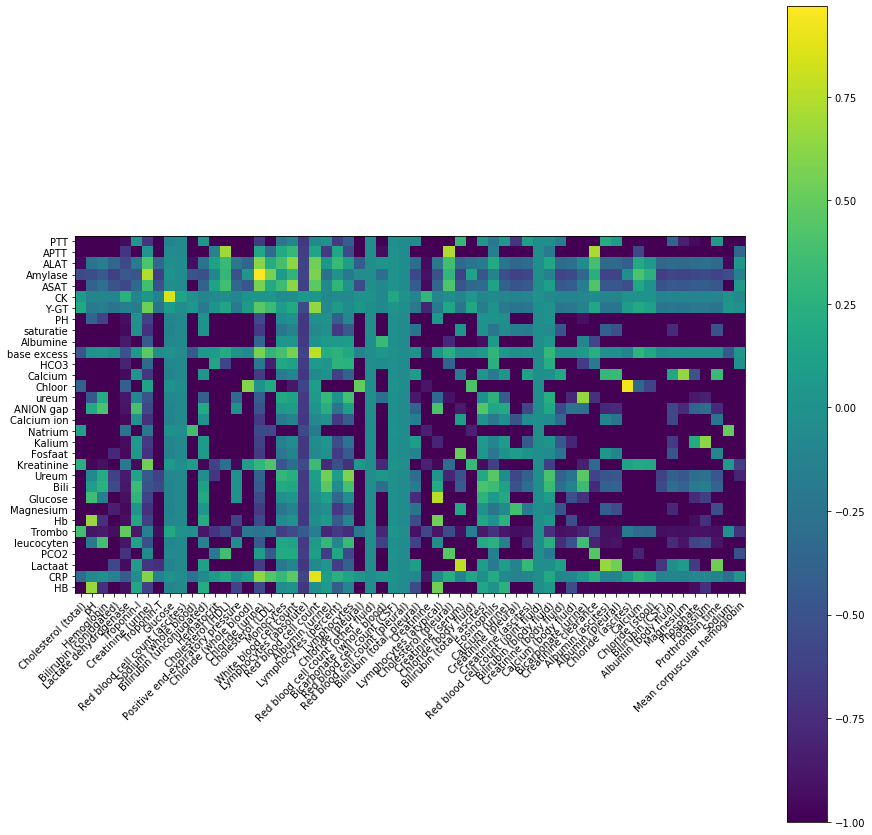

In [0]:
df = pd.DataFrame(data=dist_mat, index=labevents_icv['LEVEL1'].unique(), columns=labevents_mimic['clean_label'].unique())
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(df)
ax.set_xticks(np.arange(len(labevents_mimic['clean_label'].unique())))
ax.set_yticks(np.arange(len(labevents_icv['LEVEL1'].unique())))
ax.set_xticklabels(labevents_mimic['clean_label'].unique())
ax.set_yticklabels(labevents_icv['LEVEL1'].unique())
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.colorbar(im)

In [0]:
# import numpy as np
nl_inds, en_inds = np.where((str_mat > 80)==1)
print(nl_inds)
for i, j in zip(nl_inds, en_inds):
  print(str_mat[i, j], labevents_icv['item'].unique()[i], '----->', labevents_mimic['clean_label'].unique()[-j])

NameError: ignored

Text(0.5, 1.0, 'Amsterdam pH works')

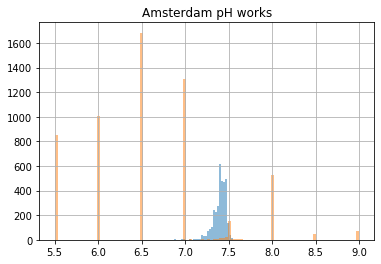

In [0]:
labevents_icv.loc[(labevents_icv['LEVEL1']=='PH') & (labevents_icv['value']<8)]['value'].hist(bins=50, alpha=0.5)
labevents_mimic.loc[labevents_mimic['clean_label']=='pH']['valuenum'].hist(bins=100, alpha=0.5)
plt.title('Amsterdam pH works')

Text(0.5, 1.0, 'MIMIC-III PH works less well...')

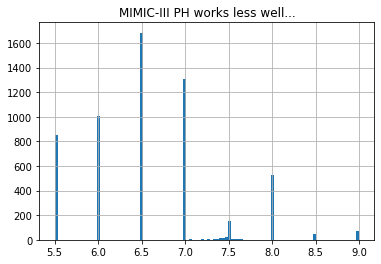

In [0]:
labevents_mimic.loc[labevents_mimic['clean_label']=='pH']['valuenum'].hist(bins=100)
plt.title('MIMIC-III PH works less well...')

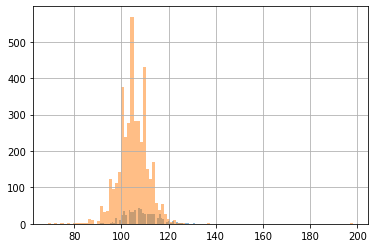

In [0]:
labevents_icv.loc[(labevents_icv['LEVEL1']=='Chloor')]['value'].hist(bins=50, alpha=0.5)
labevents_mimic.loc[labevents_mimic['clean_label']=='Chloride (whole blood)']['valuenum'].hist(bins=100, alpha=0.5)

In [0]:
import pandas as pd

df = pd.DataFrame(data=lang_similarity, index=dutch_test, columns=english_test)
plt.pcolor(df)

NameError: ignored

In [0]:
!pip install emoji --upgrade

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=3cf402d993f3790865a4c6e0e49cafbeafb3fbe9f0f81ec529f103fa7615329f
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import emoji

# write a generator which yields the most likely matches first
def likely_matches_gen(str_mat):
    # sort by order of most likely, grab the column and index for that, yield these
    while True:
        # get largest values
        curr_max = np.amax(str_mat)
        positions = np.where(str_mat == curr_max)
        position = [positions[0][0], positions[1][0]]
        yield position
        str_mat[position[0], position[1]] = 0

def get_valid_response(match):

    print("\nIs this a suitable match: ", ", ".join(match))
    user_input = input('Confirm? [Y/N] or X to exit: ')

  # ... error handling ...
    if user_input.lower() not in ('y', 'yes', 'n', 'no', 'x', 'exit'):
        print(emoji.emojize('Error: Input "{}" unrecognised. Damnit Ari! A yes or no is not that hard... :rage:', use_aliases=True).format(user_input))
        return get_valid_response(match)

    else:
        return user_input

def loop_matches_list(str_mat):

    matches = []
    non_matches = []

    mimic_vars = labevents_icv['LEVEL1'].unique()
    ams_vars = labevents_mimic['clean_label'].unique()
    match_gen = likely_matches_gen(str_mat)

    while True:
        match_ind = next(match_gen)
        match = [mimic_vars[match_ind[0]], ams_vars[match_ind[1]]]

        user_input = get_valid_response(match)
 
        if user_input.lower() in ('y', 'yes'):
           matches.append(match)
        elif user_input.lower() in ('n', 'no'):
           non_matches.append(match)
        else:  # if the user exits
            please_statement = input(emoji.emojize('Now you gotta say please... :information_desk_person::', use_aliases=True))
            if please_statement.lower() == 'please':
                print(emoji.emojize('Brexit means Brexit :wave:', use_aliases=True))
                return matches, non_matches
            else: 
                print(emoji.emojize('Fine be like that :cry:', use_aliases=True))
                return matches, non_matches

    return matches, non_matches
  
matches, non_matches = loop_matches_list(str_mat)

NameError: ignored

In [0]:
print('Saved Matches:')
print(matches)
print('Non Matches:')
print(non_matches)

Saved Matches:
[['PH', 'pH'], ['Calcium', 'Calcium'], ['Natrium', 'Sodium'], ['Kalium', 'Potassium'], ['Fosfaat', 'Phosphate'], ['Kreatinine', 'Creatinine'], ['Glucose', 'Glucose'], ['Magnesium', 'Magnesium'], ['Kreatinine', 'Creatinine (serum)']]
Non Matches:
[['Calcium ion', 'Calcium (urine)'], ['Calcium ion', 'Calcium'], ['Kreatinine', 'Creatinine (urine)']]
